In [1]:
import sys
#sys.path.insert(0, '../third/xgboost.m/python-package/build/lib/')
sys.path.insert(0, '../third/xgboost/python-package/build/lib/')

In [2]:
%pylab inline
import pandas as pd
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


In [3]:
from quadratic_weighted_kappa import quadratic_weighted_kappa

In [4]:
xgb.__version__,xgb.__file__

('0.6', '../third/xgboost/python-package/build/lib/xgboost/__init__.pyc')

In [5]:
import fastparquet
%time df=fastparquet.ParquetFile("../input/train_num_combined_latest_target_v2.parq").to_pandas()

CPU times: user 1.64 s, sys: 3.24 s, total: 4.87 s
Wall time: 4.87 s


In [6]:
df.shape

(6582476, 55)

In [7]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6582476 entries, 0 to 15203954
Columns: 55 entries, market to id_count
dtypes: float32(53), int8(2)
memory usage: 1.4 GB


In [8]:
(df.index<10000000).sum(),(df.target<0).sum()

(1378521, 1378521)

In [9]:
testx=df[df.index<10000000].drop(['target','date'],axis=1)
testx.shape

(1378521, 53)

In [10]:
df=df[df.index>=10000000]

In [11]:
df.shape

(5203955, 55)

In [12]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5203955 entries, 10000000 to 15203954
Columns: 55 entries, market to id_count
dtypes: float32(53), int8(2)
memory usage: 1.1 GB


In [13]:
import gc
gc.collect()

11183

In [14]:
import numpy as np
from numba import jit 

def clip_pred(pred):
    pred=np.round(pred)
    pred[pred<0]=0
    pred[pred>20]=20
    return pred.astype(np.int8)

@jit
def qwk(a1, a2, max_rat=20):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    w = np.zeros((max_rat + 1, max_rat + 1))
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            w[i, j] = (i - j) * (i - j)/ float(max_rat * max_rat)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for i, j in zip(a1, a2):
        hist1[i] += 1
        hist2[j] += 1
        o +=  w[i, j]

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * w[i, j]

    e = e / float(a1.shape[0])

    return 1 - o / e

@jit
def qwk3(a1, a2, max_rat=20):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / float(a1.shape[0])

    return 1 - o / e

def eval_qwk(preds, dtrain):
    labels = dtrain.get_label()
    preds=clip_pred(preds)
    qwk_score = qwk3(labels, preds)
    return [('qwk', qwk_score)]

In [15]:
df.head()

market  date       f_0       f_1       f_2       f_3       f_4  \
id                                                                           
10000000  3.981910    16  4.084971  4.256005  4.576220  0.011423  0.023838   
10000001  4.600824    16  4.572433  4.589514  4.622002  1.042093  0.922797   
10000002  4.266003    16  4.357457  4.589514  4.576220  1.441485  1.664050   
10000003  4.600824    16  4.434495  4.589514  4.576220  0.721977  0.306136   
10000004  4.600824    16  4.659207  4.589514  4.576220  1.201324  0.776684   

               f_5       f_6       f_7    ...     latest_target  count  \
id                                        ...                            
10000000  2.279448  0.000000  4.327717    ...               1.0    1.0   
10000001  4.191009  0.000000  4.336779    ...               2.0    4.0   
10000002  7.959006  0.006247  4.385122    ...               1.0    1.0   
10000003  2.859509  0.000000  4.336779    ...               3.0    2.0   
10000004  2.859509  0.000000  4.336779    ...               2.0    4.0   

              freq  latest3_mean  changed_count  latest2_change  latest2_mean  \
id                                                                              
10000000  1.000000       -9999.0            0.0         -9999.0       -9999.0   
10000001  1.000000          33.0            2.0            -2.0          30.0   
10000002  1.000000       -9999.0            0.0         -9999.0       -9999.0   
10000003  1.000000       -9999.0            1.0             1.0          25.0   
10000004  0.666667          50.0            2.0            -6.0          50.0   

          mkt_mean  mkt_count  id_count  
id                                       
10000000     1.000        3.0       3.0  
10000001     3.875        2.0      10.0  
10000002     3.000        5.0      20.0  
10000003     2.500        1.0       2.0  
10000004     4.500        2.0       5.0  

[5 rows x 55 columns]

In [16]:
dates=df['date']

In [17]:
trainx=df.drop(['target','date'],axis=1)
trainy=df['target']

In [18]:
set(dates)

{5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}

In [33]:
trainidx= (dates<15) & (dates>0)
testidx=dates>15

In [34]:
x_train, y_train, x_valid, y_valid = trainx[trainidx], trainy[trainidx], trainx[testidx], trainy[testidx]


In [35]:
print('Building DMatrix...')

d_train = xgb.DMatrix(x_train , label=y_train)
d_valid = xgb.DMatrix(x_valid , label=y_valid)

print x_train.shape,x_valid.shape
print('Training ...')

params = {}
params['eta'] = 0.2
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params['max_depth'] = 8
params['nthread']=8
params['silent'] = 1
params['tree_method']='hist'

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
%time clf = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50,verbose_eval=40,feval=eval_qwk,maximize=True)


Building DMatrix...
(4325056, 53) (441215, 53)
Training ...
[0]	train-rmse:4.19902	valid-rmse:4.26537	train-qwk:0.095148	valid-qwk:0.095369
Multiple eval metrics have been passed: 'valid-qwk' will be used for early stopping.

Will train until valid-qwk hasn't improved in 50 rounds.
[40]	train-rmse:1.86191	valid-rmse:1.87037	train-qwk:0.750102	valid-qwk:0.752145
[80]	train-rmse:1.84704	valid-rmse:1.86876	train-qwk:0.754671	valid-qwk:0.75324
[120]	train-rmse:1.83651	valid-rmse:1.86894	train-qwk:0.757621	valid-qwk:0.753583
[160]	train-rmse:1.82661	valid-rmse:1.86988	train-qwk:0.760435	valid-qwk:0.753557
[200]	train-rmse:1.81876	valid-rmse:1.87015	train-qwk:0.762673	valid-qwk:0.753878
[240]	train-rmse:1.81047	valid-rmse:1.87108	train-qwk:0.76494	valid-qwk:0.753606
Stopping. Best iteration:
[193]	train-rmse:1.82002	valid-rmse:1.87007	train-qwk:0.762295	valid-qwk:0.753941

CPU times: user 24min 11s, sys: 35.5 s, total: 24min 46s
Wall time: 3min 15s


In [36]:
x_train.shape,x_valid.shape

((4325056, 53), (441215, 53))

In [38]:
def scale_pred(y_true, y_pred):
    B=np.mean((y_true-y_true.mean())**2)
    C=np.mean((y_pred-y_pred.mean())**2)
    A=np.mean((y_true-y_pred)**2)
    
    print A,B,C, (C-A+B)/(C+B)
    
    b=np.arange(-1,1.3,0.01)
    bb=(b*(C-A)+B)/(C+b**2*B)
    print max(bb)
    plt.plot(b,bb)
    return (B/(A-C))
def clip_pred(pred):
    pred=np.round(pred)
    pred[pred<0]=0
    pred[pred>20]=20
    return pred.astype(np.int8)

In [39]:
pred=clf.predict(d_valid)

In [40]:
lst=[]
for s in np.arange(1.25,1.35,0.01):
    a= s, quadratic_weighted_kappa(y_valid,clip_pred((pred-pred.mean())*s+pred.mean()))
    print a
    lst.append(a)

(1.25, 0.7773045985872165)
(1.26, 0.7774905758150886)
(1.27, 0.7776239009993606)
(1.28, 0.7777801952206314)
(1.29, 0.7778470279413854)
(1.3, 0.7777585332116826)
(1.3100000000000001, 0.7776283660662208)
(1.3200000000000001, 0.7775637669100288)
(1.3300000000000001, 0.7774705484417735)
(1.3400000000000001, 0.7772839573989353)
(1.3500000000000001, 0.777116205853314)


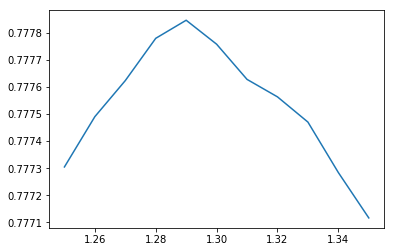

In [41]:
plt.plot(np.array(lst).T[0],np.array(lst).T[1])

In [42]:
pred=clip_pred(pred)

In [43]:
quadratic_weighted_kappa(y_valid,pred)

0.7535927018890145

In [44]:
raw_pred=clf.predict(d_train)

In [45]:
pred=clip_pred(raw_pred)
quadratic_weighted_kappa(y_train,pred)

0.7651316851488111

In [46]:
for s in np.arange(1.1,1.41,0.05):
    pred=(raw_pred-raw_pred.mean())*s+raw_pred.mean()
    pred=clip_pred(pred)
    print s, np.round(qwk3(y_train,pred),3)

1.1 0.779
1.15 0.784
1.2 0.787
1.25 0.789
1.3 0.789
1.35 0.788
1.4 0.786


# test pred

In [48]:
d_test=xgb.DMatrix(testx)

In [49]:
pred=clip_pred(clf.predict(d_test))

In [50]:
pred.shape

(1378521,)

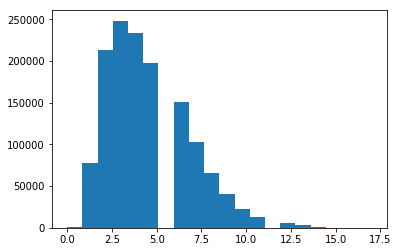

In [51]:
plt.hist(pred,bins=20);

In [52]:
sample_sub=pd.read_csv("../input/sample_submission_v2.csv",index_col=0)

/home/spark/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [53]:
sample_sub.shape

(1378521, 1)

In [54]:
this_sub=pd.DataFrame(pred,index=testx.index,columns=sample_sub.columns)

In [55]:
this_sub=this_sub.loc[sample_sub.index]

In [56]:
this_sub.isnull().sum()

target    0
dtype: int64

In [58]:
def make_submission(df,filepath):
    df.to_csv(filepath)
    zipfile=filepath+".7z"
    !rm {zipfile}
    !7za a {zipfile}  {filepath} > /dev/null
    !rm {filepath}

In [59]:
make_submission(this_sub,"../submission/simple_xgb_combined_lastmonthheldout.csv")

rm: cannot remove ‘../submission/simple_xgb_combined_lastmonthheldout.csv.7z’: No such file or directory


# test pred2

In [60]:
pred=(clf.predict(d_test))

In [61]:
pred.shape

(1378521,)

In [62]:
pred.mean()

4.4860635

In [63]:
pred=(pred-pred.mean())*1.29+pred.mean()

In [64]:
pred=clip_pred(pred)

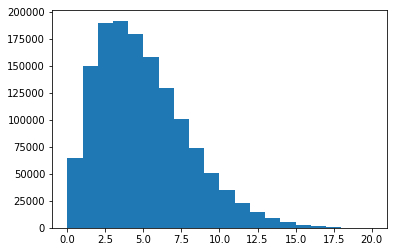

In [65]:
plt.hist(pred,bins=20);

In [66]:
sample_sub=pd.read_csv("../input/sample_submission_v2.csv",index_col=0)

In [67]:
sample_sub.shape

(1378521, 1)

In [68]:
this_sub=pd.DataFrame(pred,index=testx.index,columns=sample_sub.columns)

In [69]:
this_sub=this_sub.loc[sample_sub.index]

In [70]:
this_sub.isnull().sum()

target    0
dtype: int64

In [71]:
def make_submission(df,filepath):
    df.to_csv(filepath)
    zipfile=filepath+".7z"
    !rm {zipfile}
    !7za a {zipfile}  {filepath} > /dev/null
    !rm {filepath}

In [72]:
make_submission(this_sub,"../submission/simple_xgb_combined__lastmonthheldout_s1.29.csv")

rm: cannot remove ‘../submission/simple_xgb_combined__lastmonthheldout_s1.29.csv.7z’: No such file or directory
